# ADV Example

The following example shows a simple workflow for analyzing ADV data using DOLfYN's tools. [DOLfYN]

A typical ADCP data workflow is broken down into
  1. Review the raw data
      - Check timestamps
      - Look at velocity data quality, particularly for spiking
  2. Check for spurious datapoints and remove. Replace bad datapoints using interpolation if desired
  3. Rotate the data into principal flow coordinates (streamwise, cross-stream, vertical)
  4. Average the data into bins, or ensembles, of a set time length (normally 5 to 10 min)
  5. Calculate turbulence statistics (turbulence intensity, TKE, Reynolds stresses) of the measured flowfield

Start by importing the necessary DOLfYN tools:

In [11]:
# Import core DOLfYN functions
import dolfyn as dlfn
# Import ADV-specific API tools
import dolfyn.adv.api as api

## Read Raw Instrument Data

DOLfYN currently only carries support for the Nortek Vector ADV. The example loaded here is a short clip of a test deployment dataset to show DOLfN's capabilities. Because it's only around 15 minutes of data, analysis won't yield sensical results.

Start by reading in the raw datafile downloaded from the instrument. The `dlfn.read` function reads the raw file and dumps the information into an xarray Dataset, which contains three groups of variables. One: the velocity, amplitude, and correlation of the Doppler velocimetry; Two: measurements of the instrument's bearing and environment; and Three: the orientation matrices DOLfYN uses for rotating through coordinate frames.

In [12]:
ds = dlfn.read('../dolfyn/example_data/vector_data01.VEC')

Reading file ../dolfyn/example_data/vector_data01.VEC ...
 end of file at 3000000 bytes.


To see what's in an xarray Dataset, simply type the dataset's name. To access a particular variable in a dataset, use dict-style or attribute-style syntax. See [xarray documentation](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html) for more details on how to use the xarray format.

In [13]:
ds
# ds['vel'] or ds.vel to access the velocity variable

<xarray.Dataset>
Dimensions:              (time: 122912, dir: 3, beam: 3, x*: 3, earth: 3, inst: 3)
Coordinates:
  * time                 (time) float64 1.34e+09 1.34e+09 ... 1.34e+09 1.34e+09
  * dir                  (dir) <U1 'X' 'Y' 'Z'
  * beam                 (beam) int32 1 2 3
  * x*                   (x*) int32 1 2 3
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables:
    beam2inst_orientmat  (beam, x*) float64 2.709 -1.34 ... -0.3438 -0.3499
    c_sound              (time) float32 1.493e+03 1.493e+03 ... nan nan
    heading              (time) float32 5.6 10.5 10.51 10.52 ... nan nan nan nan
    pitch                (time) float32 -31.5 -31.7 -31.69 ... nan nan nan
    roll                 (time) float32 0.4 4.2 4.253 4.306 ... nan nan nan nan
    temp                 (time) float32 12.67 12.68 12.68 12.68 ... nan nan nan
    vel                  (dir, time) float32 -1.002 -1.008 -0.944 ... nan nan
    amp                  (dir, time) uint8 104 110 111 113 108 112 ... 0 0 0 0 0
    corr                 (dir, time) uint8 97 91 97 98 90 95 95 ... 0 0 0 0 0 0
    orientation_down     (time) bool True True True True ... True True True True
    pressure             (time) float64 5.448 5.436 5.484 5.448 ... 0.0 0.0 0.0
    orientmat            (earth, inst, time) float32 0.0832 0.155 ... -0.7065
Attributes:
    config:       {'ProLogID': 149, 'ProLogFWver': '4.08', 'config': 15412, '...
    inst_make:    Nortek
    inst_model:   Vector
    inst_type:    ADV
    rotate_vars:  ['vel']
    freq:         6000
    SerialNum:    VEC 9062
    Comments:     APL-UW vector on Tidal Turbulence Mooring in Admiralty, tim...
    fs:           32.0
    coord_sys:    inst
    has_imu:      0

## QC'ing Data

ADV velocity data tends to have spikes due to Doppler noise, and the common way to "despike" the data is by using the phase-space algorithm by Goring and Nikora (2002). DOLfYN integrates this function using a 2-step approach: create a logical mask where True corresponds to a spike detection, and then utilize an interpolation function to replace the spikes.

In [14]:
# Clean the file using the Goring+Nikora method:
mask = api.clean.GN2002(ds.vel, npt=5000)
# Replace bad datapoints via cubic spline interpolation
ds['vel'] = api.clean.clean_fill(ds['vel'], mask, npt=12, method='cubic')

print('Percent of data containing spikes: {0:.2f}%'.format(100*mask.mean()))

# If interpolation isn't desired:
ds_nan = ds.copy(deep=True)
ds_nan.coords['mask'] = (('dir','time'), ~mask)
ds_nan['vel'] = ds_nan.vel.where(ds_nan.mask)

Percent of data containing spikes: 0.73%


## Coordinate Rotations

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up (ENU) coordinates.

ADVs use an internal compass or magnetometer to determine magnetic ENU directions. The `set_declination` function takes the user supplied magnetic declination (which can be looked up online for specific coordinates) and adjusts the orientation matrix saved within the Dataset. (Note: the "heading" variable will not change).

Instruments save vector data in the coordinate system specified in the configuration file used to deploy it. To make the data useful, it must be rotated through these coordinate systems ("beam"<->"inst"<->"earth"<->"principal"), done through the `rotate2` function. If the "earth" (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset through the necessary coordinate systems to get there.

In [15]:
# First set the magnetic declination
ds_mag = dlfn.set_declination(ds, 10) # declination points 10 degrees East

# Rotate that data from the instrument to earth frame (ENU):
ds_earth = dlfn.rotate2(ds_mag, 'earth')

Once in the true ENU frame of reference, we can calculate the principal flow direction for the velocity data and rotate it into the principal frame of reference (streamwise, cross-stream, vertical). Principal flow directions are aligned with and orthogonal to the flow streamlines at the measurement location. 

First, the principal flow direction must be calculated through `'calc_principal_heading`. As a standard for DOLfYN functions, those that begin with "calc_*" require the velocity data for input. This function is different from others in DOLfYN in that it requires place the output in an attribute called "principal_heading", as shown below.

Again we use `rotate2` to change coordinate systems.

In [16]:
ds_earth.attrs['principal_heading'] = dlfn.calc_principal_heading(ds_earth.vel)
ds_stream = dlfn.rotate2(ds_earth, 'principal')

## Averaging Data
The next step in ADV analysis is to average the velocity data into time bins (ensembles) and calculate turbulence statistics. There are a couple ways to do this, and both of these methods return identical datasets.

1. Define an averaging object, create a binned dataset and calculate basic turbulence statistics. This is done by initiating an object from the `ADVBinner` class, and subsequently supplying that object with our dataset.

2. Alternatively, the functional version of ADVBinner, `calc_turbulence`.

All of the variables in the returned dataset have been bin-averaged, where each average is computed using the number of elements specified in "n_bins". Additional variables in this dataset include the turbulent kinetic energy (TKE) vector ("ds_binned.tke_vec"), the Reynold's stresses ("ds_binned.stress"), and the power spectral densities (PSD, listed as "ds_binned.psd").

In [17]:
binner = api.ADVBinner(n_bin=9600, fs=ds_stream.fs, n_fft=4096)
ds_binned = binner(ds_stream, freq_units="Hz")

ds_binned = api.calc_turbulence(ds_stream, n_bin=9600, fs=ds_stream.fs, n_fft=4096, freq_units="Hz")

The benefit to using `ADVBinner` is that one has access to all of the velocity and turbulence analysis functions that DOLfYN contains. If basic analysis will suffice, the `calc_turbulence` function is the most convienent. Either option can still utilize DOLfYN's shortcuts.

See the [DOLfYN API](https://dolfyn-xarray.readthedocs.io/en/latest/apidoc/dolfyn.binners.html) for the full list of functions and shortcuts. A few examples are shown below.

Some things to know:
- `do_*` functions return a full dataset. The first two inputs are the original dataset and the dataset containing the variables calculated by the function. If an output dataset is not given, it will create one.
- `calc_*` functions return a data variable, which can be added to the dataset with a variable of your choosing
- "shorcuts", as termed in DOLfYN, refer to functions accessible by the xarray accessor `Veldata`, as shown below. The list of characteristics available through `Veldata` are listed [here](https://dolfyn-xarray.readthedocs.io/en/latest/apidoc/dolfyn.shortcuts.html). Some shorcut variables require the raw dataset, some an averaged dataset.


In [18]:
# calculate the variance of each variable in the dataset and add to the averaged dataset
ds_binned = binner.do_var(ds_stream, out_ds=ds_binned) 

# Calculate the cross-power spectral density
ds_binned['csd'] = binner.calc_csd(ds_stream['vel'], freq_units='rad/s', n_fft_coh=4096)

# Calculated the turbulence intensity (requires a binned dataset)
ds_binned['TI'] = ds_binned.Veldata.I

Text(0.5, 1.0, 'Streamwise Direction')

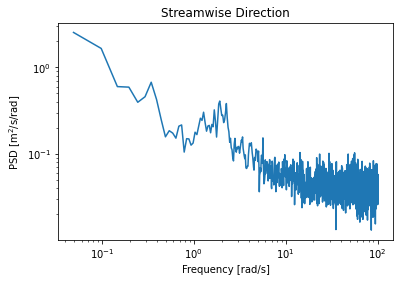

In [19]:
# Plot spectra
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.loglog(ds_binned.omega, ds_binned.psd.sel(S='Sxx').mean(dim='time'))
plt.xlabel('Frequency [rad/s]')
plt.ylabel('PSD $\mathrm{[m^2/s/rad]}$')
plt.title('Streamwise Direction')

## Saving and Loading DOLfYN datasets

In [21]:
#dlfn.save(ds, 'your_data.nc')
#ds_saved = dlfn.load('your_data.nc')